In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import sys
import os

sys.path.append('../')
from util import *
from params import *

## Dataset README

Content:
Trade flows at the year - exporter - importer - product level.
Products in Harmonized System 6-digit nomenclature.
**Values in thousand USD and quantities in metric tons.**

List of Variables:
t: year
i: exporter
j: importer
k: product
v: value
q: quantity

Reference:
Gaulier, G. and Zignago, S. (2010)
BACI: International Trade Database at the Product-Level. The 1994-2007 Version.
CEPII Working Paper, N°2010-23


# Making sense of product codes

HS92 codes are organized hierarchically, which makes it possible to aggregate them at different levels of detail. Here's a breakdown of the principles:

Chapters (2-digit level):

The first two digits of an HS code indicate the broad product category or chapter.
For example, in HS code 010111, the "01" refers to the chapter dealing with live animals.
Headings (4-digit level):

The first four digits further narrow down the category to a specific heading within that chapter.
In 010111, "0101" defines a particular type of live animal, often based on species or purpose.
Subheadings (6-digit level):

The complete six-digit code gives the most detailed level of classification under HS92.
010111 is a subheading that specifies even more precise details about the product, such as age or other characteristics.

## My comments

There seem to be ~22 ""sections"" like Arms, animals, vegetables, minerals etc. They can be found here
https://github.com/datasets/harmonized-system/blob/main/data/sections.csv

One section (eg animals) can include multiple 2-digit subsections (Horses, Cattle).


# Potential Storylines

## Overview
"How the world of trade changed after the end of history"

* The rise of China as an export superpower
* The impact of wars (Ukraine, Balkans, Syria, Russia++)
* Who makes what - who makes our cars, food, etc
* De-industralization in western countries
* The rise of India?
* Energy independence. Is the world more or less dependent in terms of energy? Which countries became more and which became less independent?
* Country-by-country (or region):
  * Ukraine (Grain, weapons, energy)
  * Germany (Stuck exporting old-inudstry products)
  * China
  * Africa (What is going on? Food dependence levels)
  * Mexico (Manufacturer of the US)
  * Russia (change of export policies after Sanctions)

In [2]:
print("Current Directory:", os.getcwd())
assert "eda" in os.getcwd(), f"Run the Jupyter server from DataVis/Team37/src/eda (not from {os.getcwd()})"

Current Directory: /home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda


In [3]:
# print(f"The loaded data has the following structure and size:\n{data_df.info(memory_usage='deep')}")

In [4]:
data_df, epc22_df, pc_df, cc_df = util.load_all_data()
print("======== Main Dataset ========")
print(data_df)
print("======== Chapter names ========")
print(epc22_df.to_string())
print("======== Product codes ========")
print(pc_df)
print("======== Country codes ========")
print(cc_df)

Loading pickle: /home/prasopou/Documents/PhD/Courses/DataVis/Team37/data/BACI_HS92_V202501/country_codes_V202501.pkl
Loading pickle: /home/prasopou/Documents/PhD/Courses/DataVis/Team37/data/BACI_HS92_V202501/product_codes_HS92_V202501.pkl
Loading pickle: /home/prasopou/Documents/PhD/Courses/DataVis/Team37/data/harmonized-system_22.pkl
Loading pickle: /home/prasopou/Documents/PhD/Courses/DataVis/Team37/data/BACI_HS92_V202501/BACI_HS92_all.pkl
Found all_data pickle
======== Main Dataset ========
          year  exporter  importer product_chapter    value  quantity
0         1995         4        12              84   36.687     5.812
1         1995         4        20              57   11.060     0.195
2         1995         4        36              57   28.774     1.002
3         1995         4        36              80   12.865    15.000
4         1995         4        40              12   38.590    31.800
...        ...       ...       ...             ...      ...       ...
21371325  2

# Data Analysis

## Aggregates

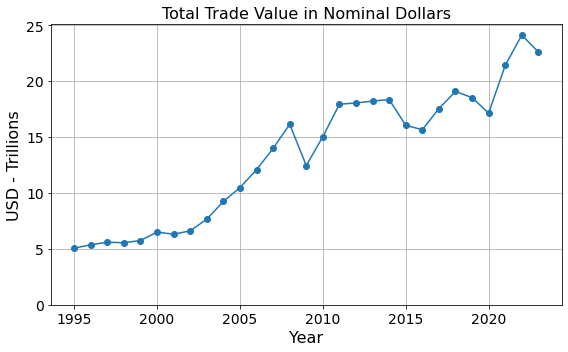

In [5]:
# Trade value and quantity of All countries and products by year
by_year = data_df.groupby('year').agg({"value": "sum", "quantity": "sum"})
by_year.reset_index(inplace=True)
by_year = standard_unit_and_name_conversions(by_year)
util.plot_lines(by_year, "year", "value_trln_USD", title="Total Trade Value in Nominal Dollars", 
                xtitle="Year", ytitle="USD - Trillions", ymin=0)
util.plot_lines(by_year, "year", "quantity_mln_metric_tons", title="Total Trade Quantity in Million Metric Tons", 
                xtitle="Year", ytitle="Metric Tons - Millions", ymin=0)

## By product chapter

In [11]:
def plot_top_n(df_ch, metric="product_chapter", keep_n=10, 
               title_pref="Total Trade Value in Nominal Dollars", legend_ncols=1, stack=True,
              stack_norm=False, valuecol="value", quantcol="quantity", plot_other=True, legend_out=False):
    # Group by product_chapter
    try:
        df_ch = df_ch.groupby(["year", metric]).agg({valuecol: "sum", quantcol: "sum"})
    except Exception as e:
        print(e)
        print(df_ch.columns)
        print(df_ch)
    df_ch.reset_index(inplace=True)
    if valuecol == "value":
        df_ch = standard_unit_and_name_conversions(df_ch)
    # Pivot, make each chapter a column
    df_ch = df_ch.pivot(index='year', columns=metric, values='value_trln_USD')
    df_ch.reset_index(inplace=True)
    # Keep top n
    top_n = list(df_ch.mean(axis=0).sort_values(ascending=False).iloc[1:keep_n+1].index)
    rest = list(set(df_ch.columns[1:]) - set(top_n))
    new_df = pd.DataFrame(index=df_ch.index)
    new_df["year"] = df_ch["year"]
    # Sum the rest
    if plot_other:
        new_df["other"] = df_ch[rest].sum(axis=1)
    for col in top_n:
        new_df[col] = df_ch[col]

    util.plot_lines(new_df, "year", new_df.columns[1:], title=f"{title_pref} (top {keep_n})", 
                    xtitle="Year", ytitle="USD - Trillions", ymin=0, stacked=stack, 
                    legend_ncols=legend_ncols, stack_norm=stack_norm, legend_out=legend_out)


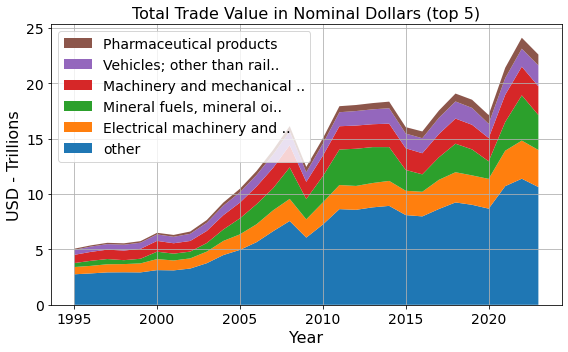

In [12]:
# Map the chapter code to the chapter name
df_ch = data_df.copy()
df_ch['product_chapter'] = df_ch['product_chapter'].map(epc22_df.set_index('hscode')['description'])
plot_top_n(df_ch, metric="product_chapter", keep_n=5)
plot_top_n(df_ch, metric="product_chapter", keep_n=10)
del df_ch

## By importer/exporter

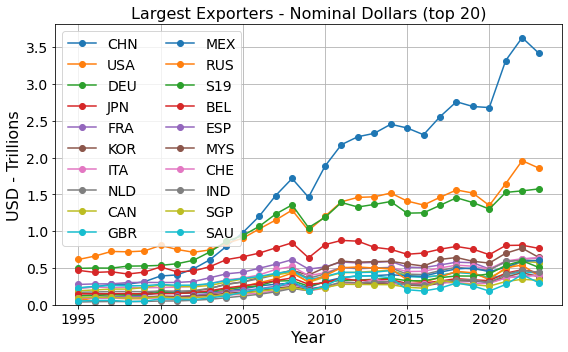

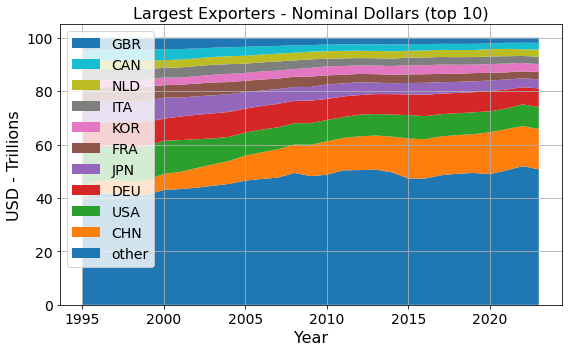

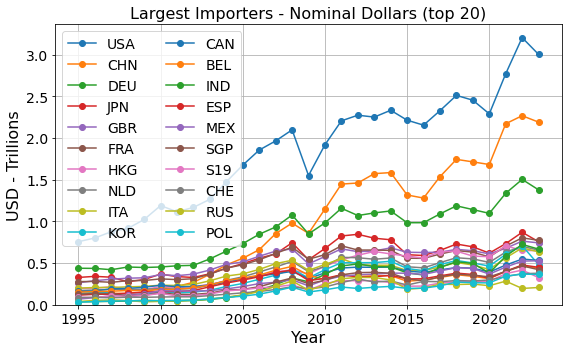

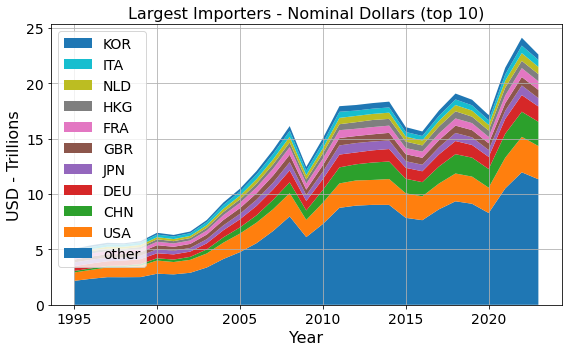

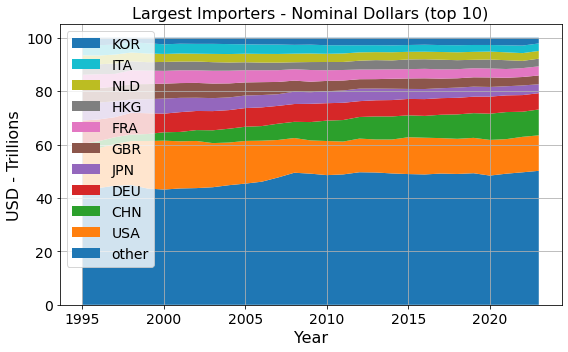

In [13]:
# Map country code to country name
df_ch = data_df.copy()
df_ch['exporter'] = df_ch['exporter'].map(cc_df.set_index('country_code')['country_iso3'])
df_ch['importer'] = df_ch['importer'].map(cc_df.set_index('country_code')['country_iso3'])

# Start by biggest exporters
plot_top_n(df_ch, metric="exporter", keep_n=20, title_pref="Largest Exporters - Nominal Dollars", stack=False, plot_other=False, legend_ncols=2)
plot_top_n(df_ch, metric="exporter", keep_n=10, title_pref="Largest Exporters - Nominal Dollars")
plot_top_n(df_ch, metric="exporter", keep_n=10, title_pref="Largest Exporters - Nominal Dollars", stack_norm=True)
plot_top_n(df_ch, metric="importer", keep_n=20, title_pref="Largest Importers - Nominal Dollars", stack=False, plot_other=False, legend_ncols=2)
plot_top_n(df_ch, metric="importer", keep_n=10, title_pref="Largest Importers - Nominal Dollars")
plot_top_n(df_ch, metric="importer", keep_n=10, title_pref="Largest Importers - Nominal Dollars", stack_norm=True)
del df_ch

In [14]:
def plot_for_country(df, country_iso3="CHN", focus="exporter"):
    """Assumes will receive df with ISO3 names as importer and exporter."""
    # Cols: year exporter importer product_chapter  value_trln_USD quantity_mln_metric_tons

    # Isolate country as importer and exporter
    df_imp = df[df["importer"] == country_iso3]
    df_imp_excl = df[df["importer"] != country_iso3]
    df_exp = df[df["exporter"] == country_iso3]
    df_exp_excl = df[df["importer"] != country_iso3]
    
    # Plot yealy imports/exports and balance
    df_imp_yrly = df_imp.groupby(["year"]).agg({"value_trln_USD": "sum", "quantity_mln_metric_tons": "sum"})
    df_exp_yrly = df_exp.groupby(["year"]).agg({"value_trln_USD": "sum", "quantity_mln_metric_tons": "sum"})
    
    df_imp_yrly.rename(columns={'value_trln_USD': 'imports_trln_USD'}, inplace=True)
    df_exp_yrly.rename(columns={'value_trln_USD': 'exports_trln_USD'}, inplace=True)

    df_yrly = df_imp_yrly.copy()
    df_yrly["exports_trln_USD"] = df_exp_yrly["exports_trln_USD"]
    df_yrly["balance_trln_USD"] = df_yrly["exports_trln_USD"] - df_yrly["imports_trln_USD"]
    start_yr = df_yrly.index.min()
    end_yr = df_yrly.index.max()
    df_yrly.reset_index(inplace=True)
    # Plot absolute values
    util.plot_lines(df_yrly, "year", ["exports_trln_USD", "imports_trln_USD", "balance_trln_USD"], title=f"{country_iso3} Imports/Exports Nominal Dollars", 
                xtitle="Year", ytitle="USD - Trillions")
    # Plot values normalized to the beginning of time
    util.plot_lines(df_yrly, "year", ["exports_trln_USD", "imports_trln_USD", "balance_trln_USD"], title=f"{country_iso3} Imports/Exports Nominal Dollars", 
                xtitle="Year", ytitle=f"Normalized to {start_yr}", normalize_to_xpoint=start_yr)
    
    # Plot country as a percentage of global imports/exports.
    df_imp_excl_yrly = df_imp_excl.groupby(["year"]).agg({"value_trln_USD": "sum", "quantity_mln_metric_tons": "sum"})
    df_exp_excl_yrly = df_exp_excl.groupby(["year"]).agg({"value_trln_USD": "sum", "quantity_mln_metric_tons": "sum"})
    df_ratio = pd.DataFrame(index=df_imp_excl_yrly.index)
    df_ratio["import_ratio"] = (df_imp_yrly["imports_trln_USD"] / df_imp_excl_yrly["value_trln_USD"]).mul(100.0)
    df_ratio["export_ratio"] = (df_exp_yrly["exports_trln_USD"] / df_imp_excl_yrly["value_trln_USD"]).mul(100.0)
    df_ratio.reset_index(inplace=True)
    util.plot_lines(df_ratio, "year", ["import_ratio", "export_ratio"], 
                    title=f"{country_iso3} Percentage of Total Imports/Exports", 
                    xtitle="Year", ytitle="%", ymin=0)

    ################################################################################
    # Plot the categories in which the country is most prominent in import/exports
    plot_top_n(df_imp, metric="product_chapter", keep_n=7, title_pref=f"{country_iso3} Imports Value in Nominal Dollars", valuecol="value_trln_USD", quantcol="quantity_mln_metric_tons")
    plot_top_n(df_imp, metric="product_chapter", keep_n=7, title_pref=f"{country_iso3} Imports Value in Nominal Dollars", valuecol="value_trln_USD", quantcol="quantity_mln_metric_tons", stack=False)
    plot_top_n(df_imp, metric="product_chapter", keep_n=20, title_pref=f"{country_iso3} Imports Value in Nominal Dollars", valuecol="value_trln_USD", quantcol="quantity_mln_metric_tons", stack=False, legend_out=True, legend_ncols=2)
    plot_top_n(df_exp, metric="product_chapter", keep_n=7, title_pref=f"{country_iso3} Exports Value in Nominal Dollars", valuecol="value_trln_USD", quantcol="quantity_mln_metric_tons")    
    plot_top_n(df_exp, metric="product_chapter", keep_n=7, title_pref=f"{country_iso3} Exports Value in Nominal Dollars", valuecol="value_trln_USD", quantcol="quantity_mln_metric_tons", stack=False)    
    plot_top_n(df_exp, metric="product_chapter", keep_n=20, title_pref=f"{country_iso3} Exports Value in Nominal Dollars", valuecol="value_trln_USD", quantcol="quantity_mln_metric_tons", stack=False, legend_out=True, legend_ncols=2)
    
    ################################################################################
    # Now plot the top N imports or exports in terms of percentage vs total trade.
    df_focus = df_imp if focus=="importer" else df_exp
    df_excl_focus = df_imp_excl if focus=="importer" else df_exp_excl
    total_categories = df_focus["product_chapter"].nunique()
    df_focus = df_focus.copy().groupby(["year", "product_chapter"]).agg({"value_trln_USD": "sum"})
    df_excl_focus = df_excl_focus.copy().groupby(["year", "product_chapter"]).agg({"value_trln_USD": "sum"})
    df_focus_ratio = df_focus / df_excl_focus
    
    df_focus_ratio.reset_index(inplace=True)
    df_focus_ratio = df_focus_ratio.pivot(index='year', columns="product_chapter", values='value_trln_USD')
    
    # Keep the ones in which the country is most dominant during the last year of data
    keep_n = 20
    top_n = list(df_focus_ratio.iloc[-1].sort_values(ascending=False).iloc[:keep_n+1].index)
    rest = list(set(df_focus_ratio.columns) - set(top_n))
    new_df = pd.DataFrame(index=df_focus_ratio.index)
#     # Sum the rest
#     new_df["other"] = df_focus_ratio[rest].sum(axis=1)
    for col in top_n:
        new_df[col] = df_focus_ratio[col]

    new_df.reset_index(inplace=True) # Make year a column
    util.plot_lines(new_df, "year", new_df.columns[1:], title=f"{country_iso3} top {keep_n}/{total_categories} product categories - {focus}", 
                    xtitle="Year", ytitle="Ratio vs Global Total", ymin=0, stacked=False, 
                    legend_ncols=2, stack_norm=False, legend_out=True)
    
    # TODO: Plot the largest importers from this country and the lagest importers from this country
    # TODO: do plot many categories of imports and exports with an outside legend.

In [15]:
df_ch = data_df.copy()
df_ch = standard_unit_and_name_conversions(df_ch)
df_ch['product_chapter'] = df_ch['product_chapter'].map(epc22_df.set_index('hscode')['description'])
df_ch['exporter'] = df_ch['exporter'].map(cc_df.set_index('country_code')['country_iso3'])
df_ch['importer'] = df_ch['importer'].map(cc_df.set_index('country_code')['country_iso3'])

# Story -  China - The rise of

.. After the "end of history" - ie since 1995 for which we have data:

* China exports almost 2x as much as the next larges exporter while it was not even in the top 3 in 1995.
* Has been consistently importing ~60% of what it exports in dollar terms.
* Currently a very strong player in certain product categories such as Electrical machinery (~35% of total exports and Toys/Games (~60%). Interestingly also exports ~80% of exported umbrellas.

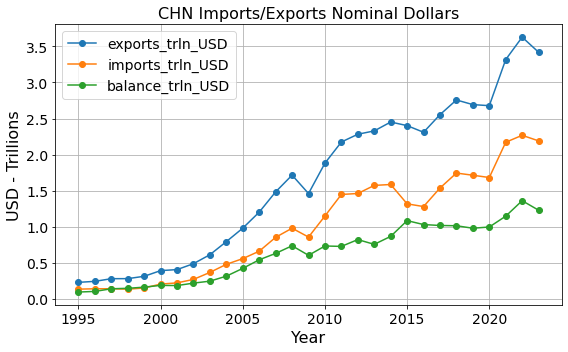

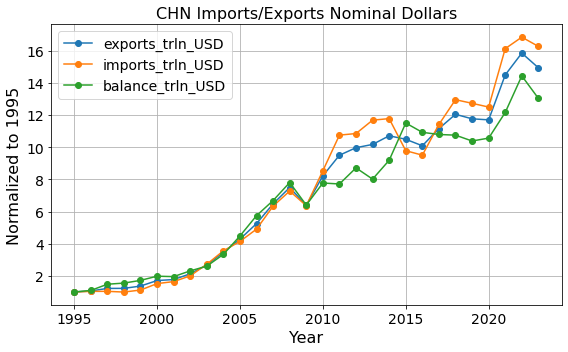

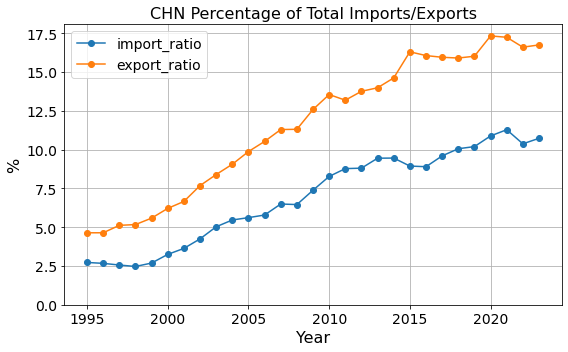

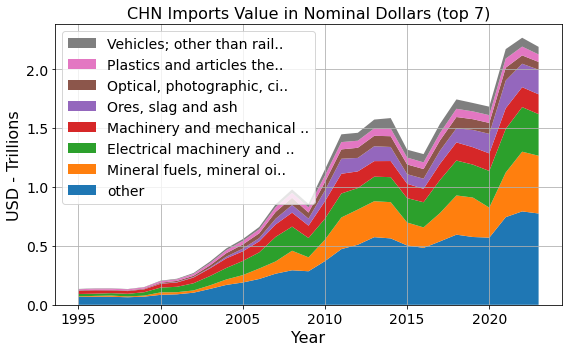

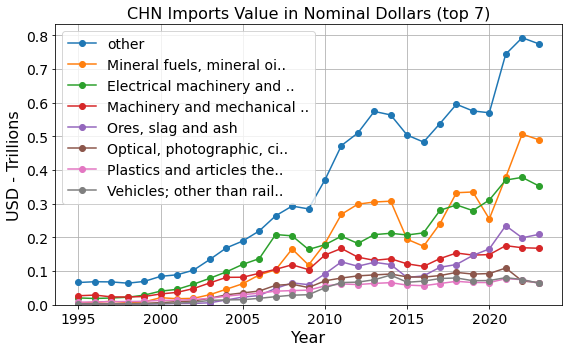

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


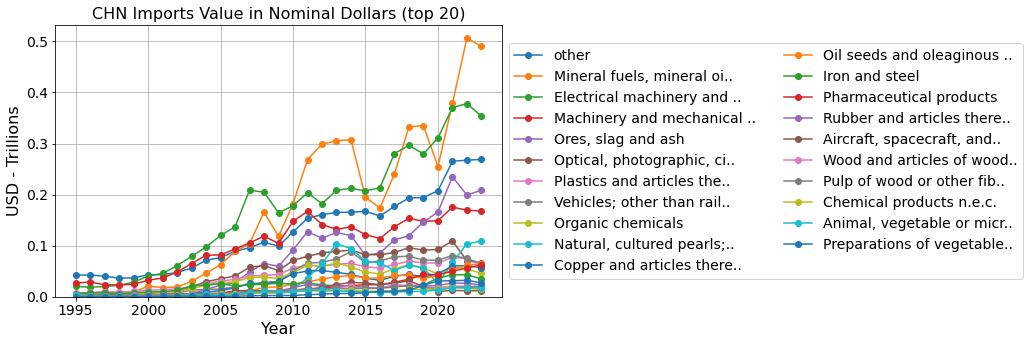

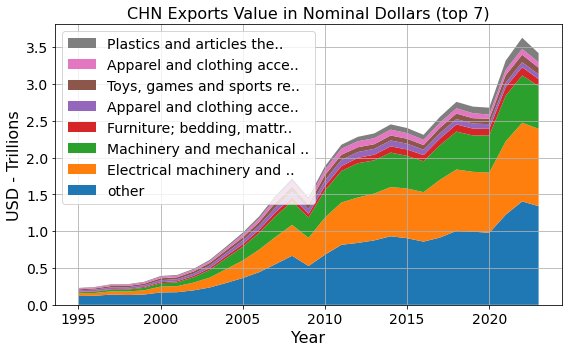

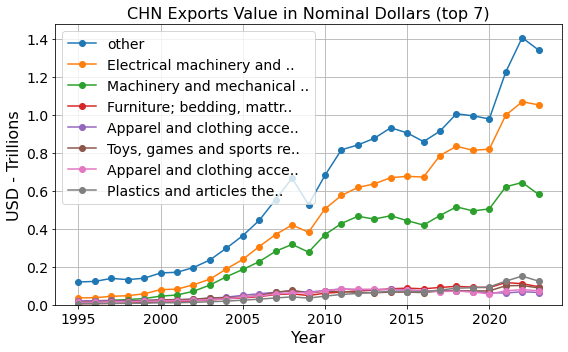

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


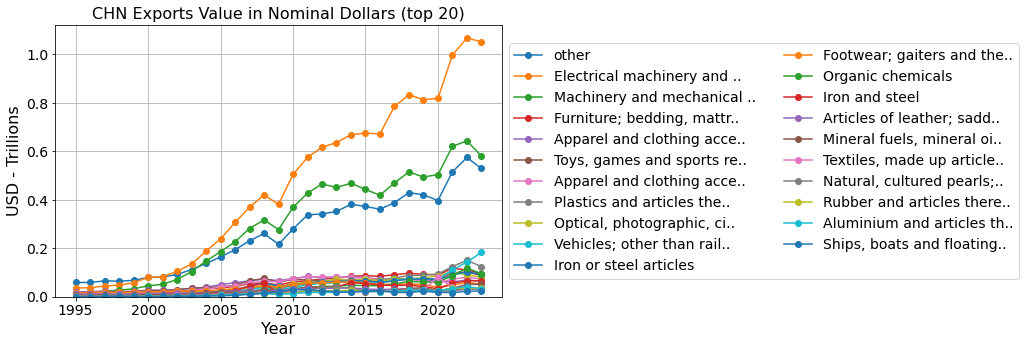

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


In [16]:
plot_for_country(df_ch, "CHN", focus="exporter")

# Story -  USA - The mirror of China?

* The US exports ~60% of what it imports in terms of nominal dollars.
* The largest import categories is machinery (the largest export categories of China).
* Import of mineral fuels has decreased significantly from the peak in 2008.
* Largest import categories in 2023: Mahinery (1&2), vehicles, mineral fuels, pharma, and chips (I presume)
* Largest export categories in 2023: Mineral Fuels, machinery (2&3), vehicles, chips (again?).
* The US imports 40% of the worlds toy and game exports.

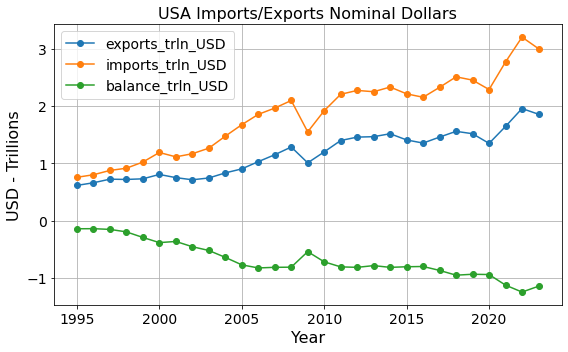

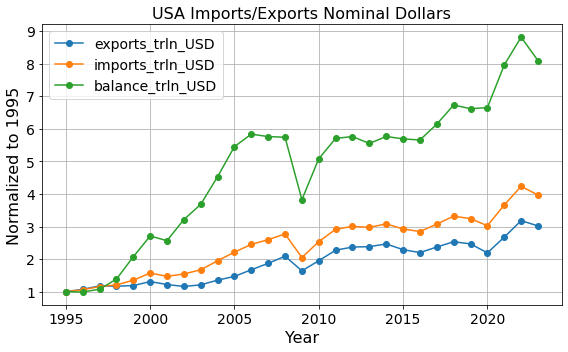

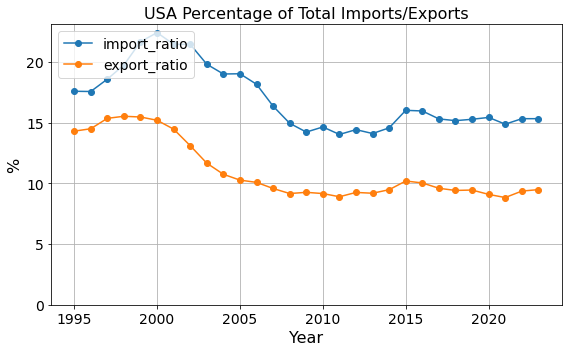

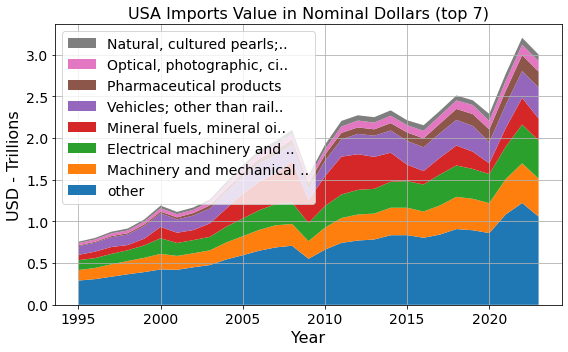

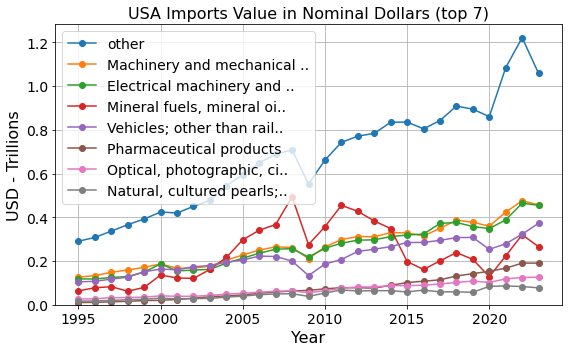

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


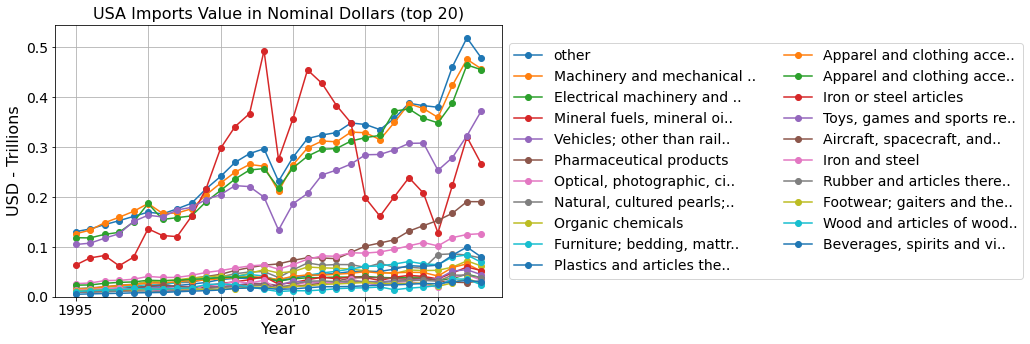

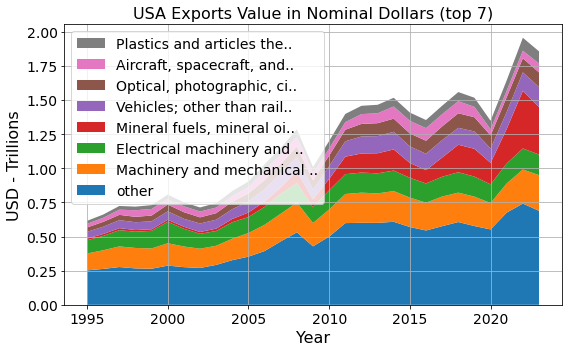

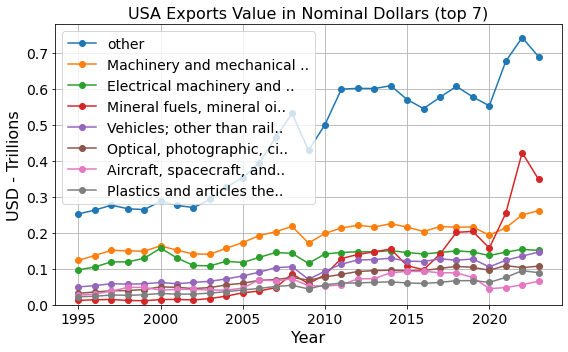

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


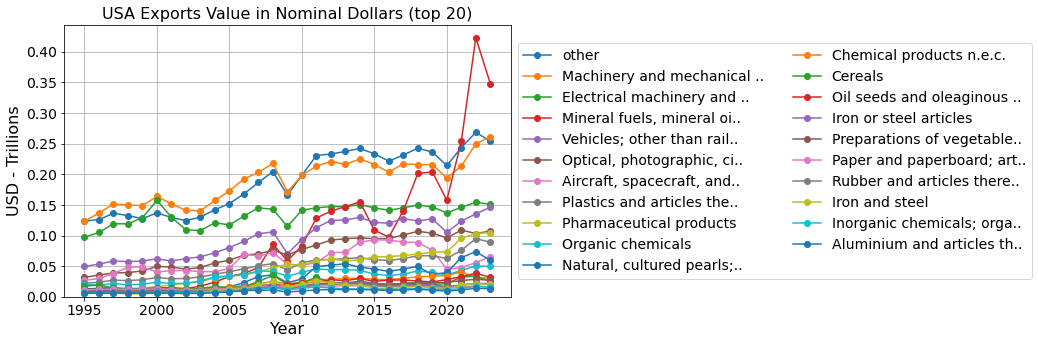

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


In [17]:
plot_for_country(df_ch, "USA", focus="importer")

# Story - War - Ukraine

* Iron and steel exports collapsed in 2022 and 2023. Same for export of ores.
* Cereal exports also fell (I supposed this is the category of grain)
* The already volatile trade profile did not change too much from the war, even though exports are at the level of 2005 in nominal terms - so, terrible.


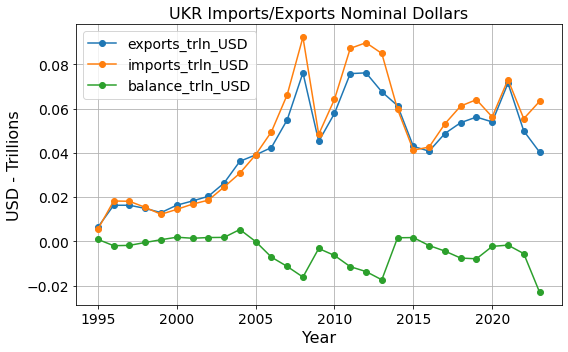

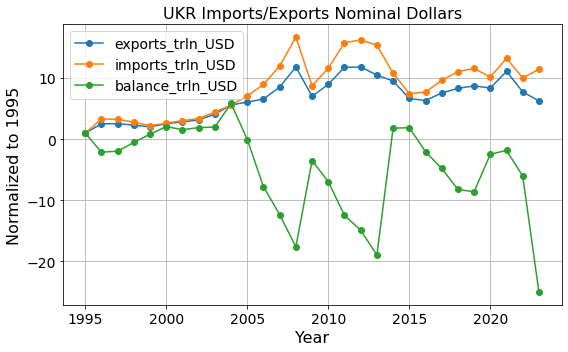

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


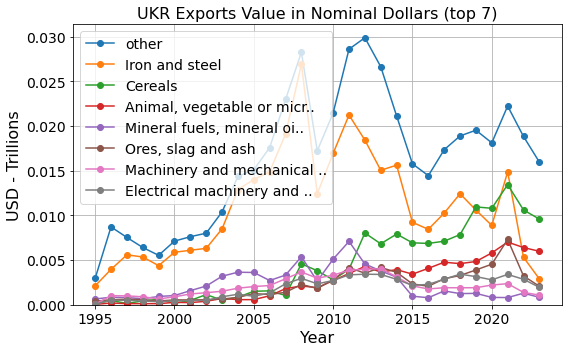

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


In [18]:
plot_for_country(df_ch, "UKR", focus="exporter")

# Story - War - Russia

* Russia imports ~60% of what it imports in dollar terms
* There is no radical discontinuity in 2022. It's imports that fell in 2022.
* Noticeable drop in machinery (mech and elec) imports in 2022.
* Russian exports completely dominated by mineral fuels.
* Russian exports accound for 15% of the total for fertilizers (in USD) and 7.5% for mineral fuels. The latter was ~10% of the total before 2022.


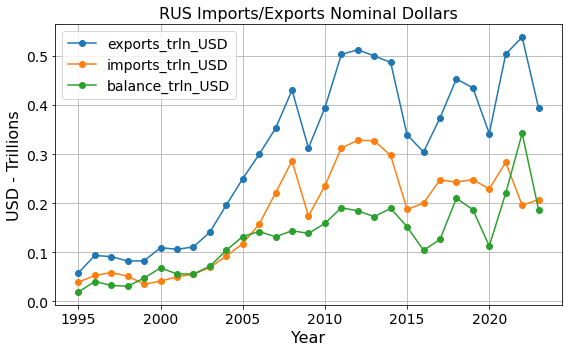

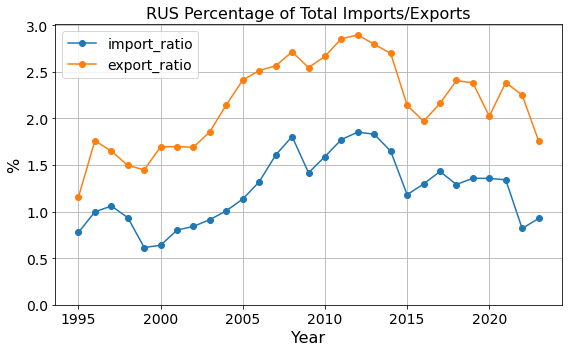

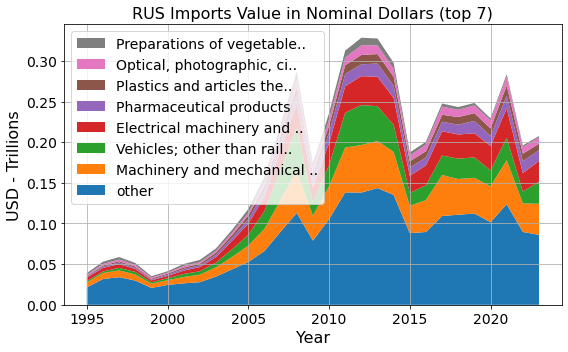

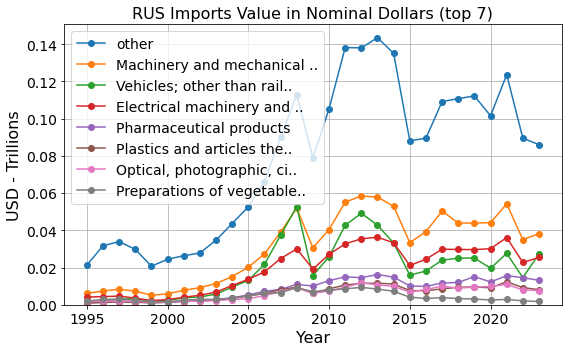

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


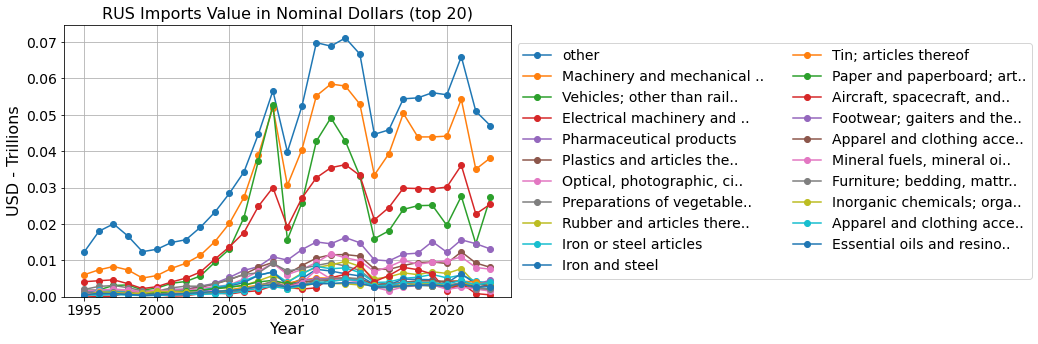

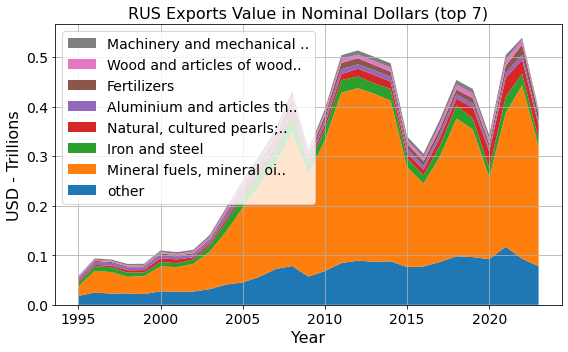

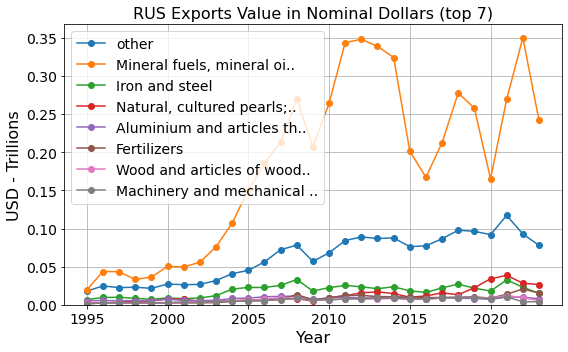

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


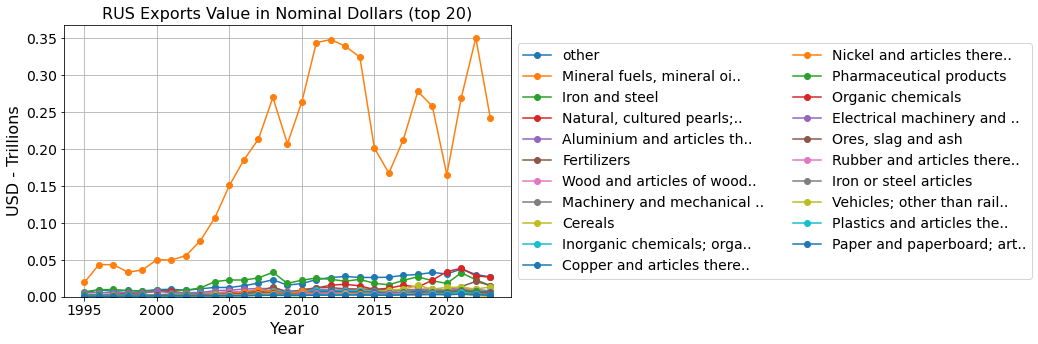

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


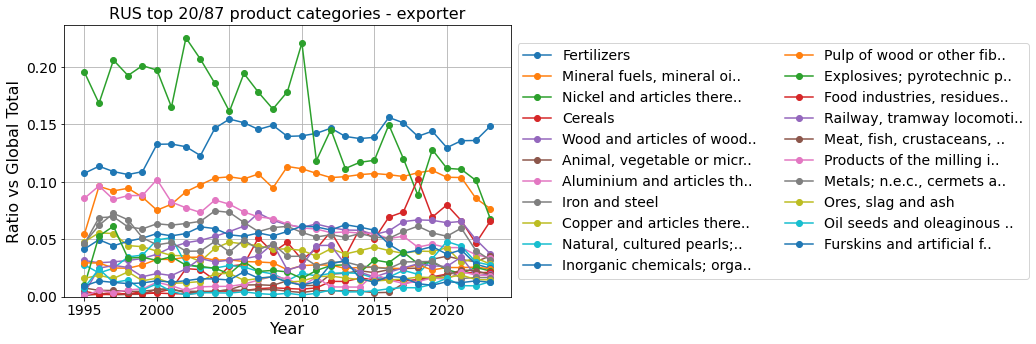

In [19]:
plot_for_country(df_ch, "RUS", focus="exporter")

# Story - War - Syria

* (Documented) Exports fell by ~90% because of the war. Imports fell by ~70%.
* Syria used to export mineral fuels (for the most part). One wonders if it still does but through backalleys.

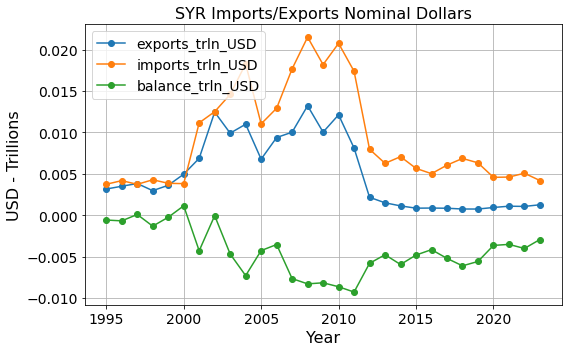

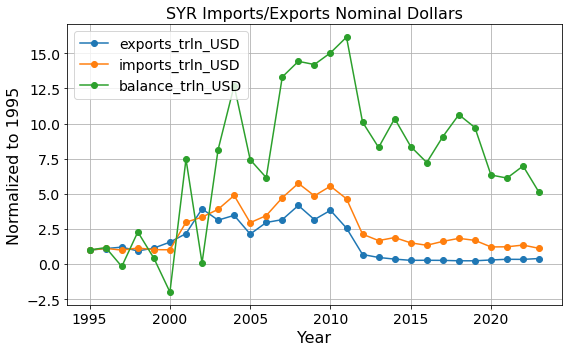

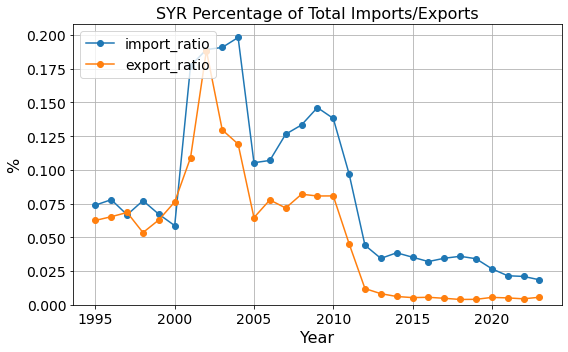

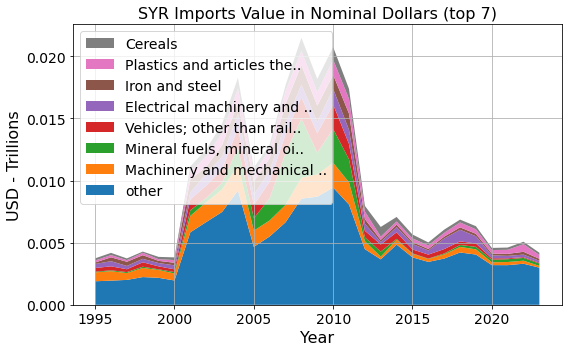

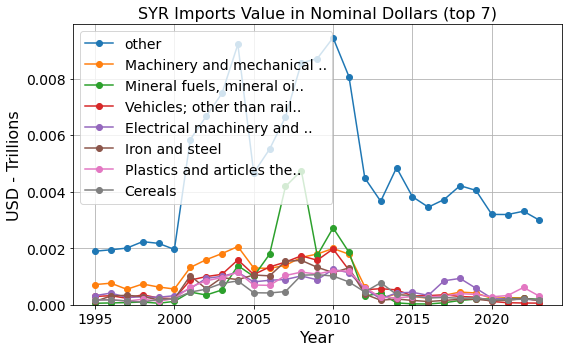

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


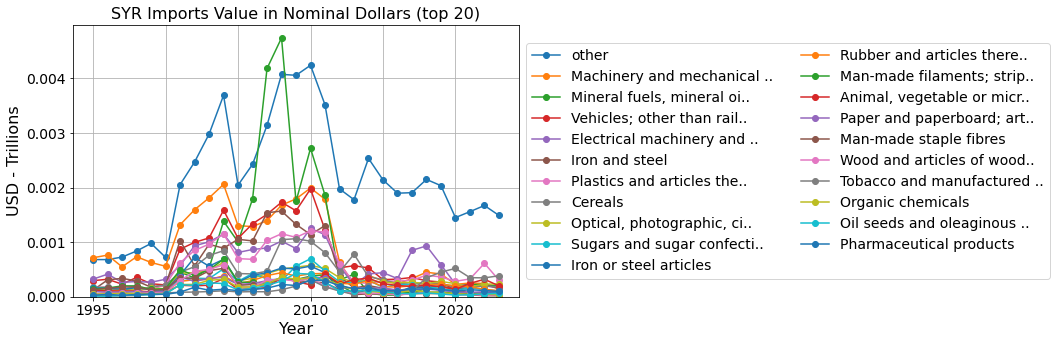

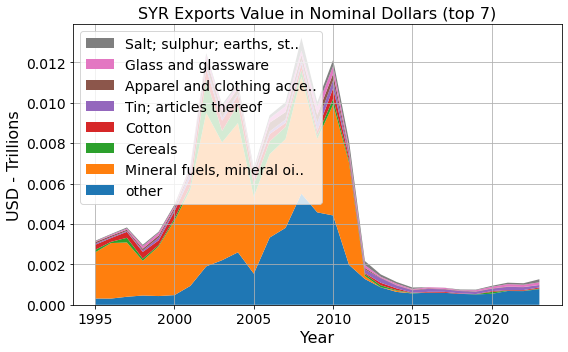

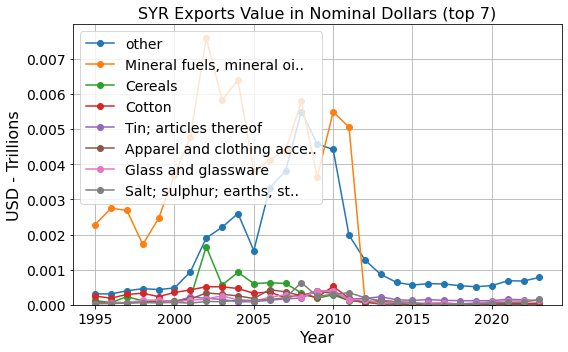

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


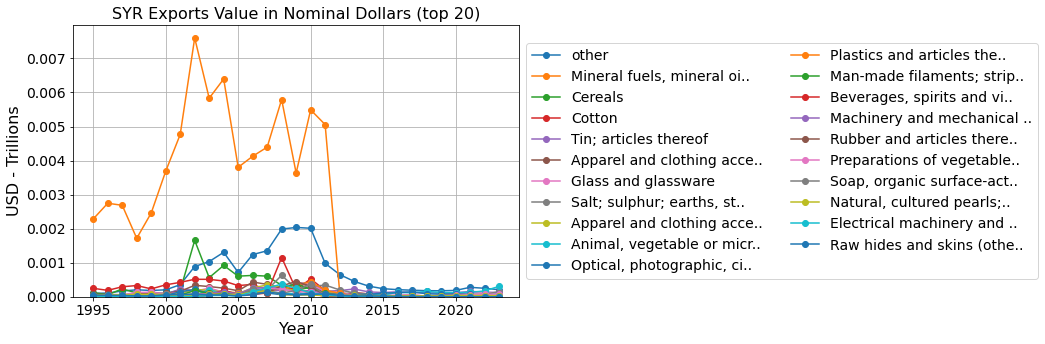

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


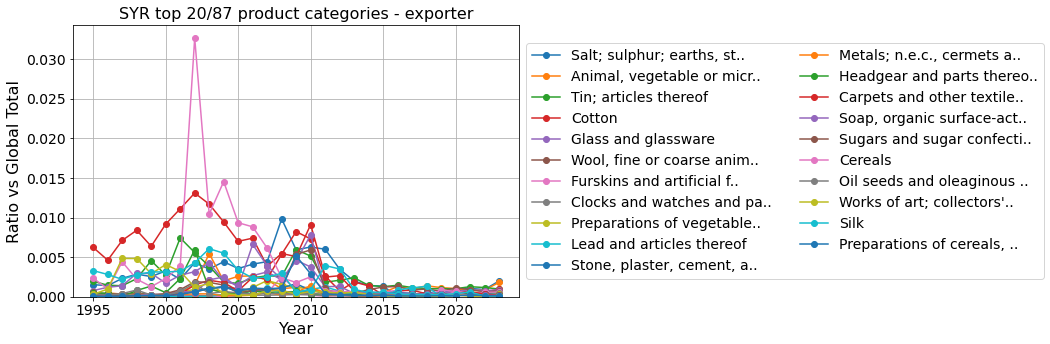

In [20]:
plot_for_country(df_ch, "SYR", focus="exporter")

In [21]:
# Chapter names
#      section hscode                                                                                                                                                                                                                                description
# 0          I     01                                                                                                                                                                                                                              Animals; live
# 41         I     02                                                                                                                                                                                                                 Meat and edible meat offal
# 118        I     03                                                                                                                                                                             Fish and crustaceans, molluscs and other aquatic invertebrates
# 353        I     04                                                                                                                           Dairy produce; birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included
# 397        I     05                                                                                                                                                                            Animal originated products; not elsewhere specified or included
# 422       II     06                                                                                                                                                Trees and other plants, live; bulbs, roots and the like; cut flowers and ornamental foliage
# 443       II     07                                                                                                                                                                                            Vegetables and certain roots and tubers; edible
# 531       II     08                                                                                                                                                                                     Fruit and nuts, edible; peel of citrus fruit or melons
# 616       II     09                                                                                                                                                                                                               Coffee, tea, mate and spices
# 666       II     10                                                                                                                                                                                                                                    Cereals
# 701       II     11                                                                                                                                                                     Products of the milling industry; malt, starches, inulin, wheat gluten
# 738       II     12                                                                                                                   Oil seeds and oleaginous fruits; miscellaneous grains, seeds and fruit, industrial or medicinal plants; straw and fodder
# 803       II     13                                                                                                                                                                                    Lac; gums, resins and other vegetable saps and extracts
# 817       II     14                                                                                                                                                       Vegetable plaiting materials; vegetable products not elsewhere specified or included
# 825      III     15                                                                                                                  Animal, vegetable or microbial fats and oils and their cleavage products; prepared edible fats; animal or vegetable waxes
# 900       IV     16                                                                                                                                         Meat, fish, crustaceans, molluscs or other aquatic invertebrates, or insects; preparations thereof
# 948       IV     17                                                                                                                                                                                                             Sugars and sugar confectionery
# 970       IV     18                                                                                                                                                                                                               Cocoa and cocoa preparations
# 988       IV     19                                                                                                                                                                      Preparations of cereals, flour, starch or milk; pastrycooks' products
# 1013      IV     20                                                                                                                                                                           Preparations of vegetables, fruit, nuts or other parts of plants
# 1075      IV     21                                                                                                                                                                                                          Miscellaneous edible preparations
# 1098      IV     22                                                                                                                                                                                                             Beverages, spirits and vinegar
# 1132      IV     23                                                                                                                                                                       Food industries, residues and wastes thereof; prepared animal fodder
# 1165      IV     24         Tobacco and manufactured tobacco substitutes; products, whether or not containing nicotine, intended for inhalation without combustion; other nicotine containing products intended for the intake of nicotine into the human body
# 1186       V     25                                                                                                                                                                        Salt; sulphur; earths, stone; plastering materials, lime and cement
# 1283       V     26                                                                                                                                                                                                                         Ores, slag and ash
# 1342       V     27                                                                                                                                       Mineral fuels, mineral oils and products of their distillation; bituminous substances; mineral waxes
# 1402      VI     28                                                                                                    Inorganic chemicals; organic and inorganic compounds of precious metals; of rare earth metals, of radio-active elements and of isotopes
# 1633      VI     29                                                                                                                                                                                                                          Organic chemicals
# 2086      VI     30                                                                                                                                                                                                                    Pharmaceutical products
# 2138      VI     31                                                                                                                                                                                                                                Fertilizers
# 2168      VI     32                                                                                        Tanning or dyeing extracts; tannins and their derivatives; dyes, pigments and other colouring matter; paints, varnishes; putty, other mastics; inks
# 2229      VI     33                                                                                                                                                                   Essential oils and resinoids; perfumery, cosmetic or toilet preparations
# 2266      VI     34  Soap, organic surface-active agents; washing, lubricating, polishing or scouring preparations; artificial or prepared waxes, candles and similar articles, modelling pastes, dental waxes and dental preparations with a basis of plaster
# 2298      VI     35                                                                                                                                                                                 Albuminoidal substances; modified starches; glues; enzymes
# 2321      VI     36                                                                                                                                             Explosives; pyrotechnic products; matches; pyrophoric alloys; certain combustible preparations
# 2341      VI     37                                                                                                                                                                                                      Photographic or cinematographic goods
# 2379      VI     38                                                                                                                                                                                                                   Chemical products n.e.c.
# 2515     VII     39                                                                                                                                                                                                              Plastics and articles thereof
# 2673     VII     40                                                                                                                                                                                                                Rubber and articles thereof
# 2771    VIII     41                                                                                                                                                                                      Raw hides and skins (other than furskins) and leather
# 2820    VIII     42                                                                                                Articles of leather; saddlery and harness; travel goods, handbags and similar containers; articles of animal gut (other than silk-worm gut)
# 2846    VIII     43                                                                                                                                                                                          Furskins and artificial fur; manufactures thereof
# 2863      IX     44                                                                                                                                                                                                   Wood and articles of wood; wood charcoal
# 3013      IX     45                                                                                                                                                                                                                  Cork and articles of cork
# 3025      IX     46                                                                                                                                                      Manufactures of straw, esparto or other plaiting materials; basketware and wickerwork
# 3039       X     47                                                                                                                                         Pulp of wood or other fibrous cellulosic material; recovered (waste and scrap) paper or paperboard
# 3068       X     48                                                                                                                                                                       Paper and paperboard; articles of paper pulp, of paper or paperboard
# 3192       X     49                                                                                                                        Printed books, newspapers, pictures and other products of the printing industry; manuscripts, typescripts and plans
# 3222      XI     50                                                                                                                                                                                                                                       Silk
# 3239      XI     51                                                                                                                                                                          Wool, fine or coarse animal hair; horsehair yarn and woven fabric
# 3291      XI     52                                                                                                                                                                                                                                     Cotton
# 3428      XI     53                                                                                                                                                                       Vegetable textile fibres; paper yarn and woven fabrics of paper yarn
# 3462      XI     54                                                                                                                                                                       Man-made filaments; strip and the like of man-made textile materials
# 3543      XI     55                                                                                                                                                                                                                     Man-made staple fibres
# 3670      XI     56                                                                                                                                          Wadding, felt and nonwovens, special yarns; twine, cordage, ropes and cables and articles thereof
# 3710      XI     57                                                                                                                                                                                                  Carpets and other textile floor coverings
# 3740      XI     58                                                                                                                                            Fabrics; special woven fabrics, tufted textile fabrics, lace, tapestries, trimmings, embroidery
# 3789      XI     59                                                                                                                         Textile fabrics; impregnated, coated, covered or laminated; textile articles of a kind suitable for industrial use
# 3825      XI     60                                                                                                                                                                                                              Fabrics; knitted or crocheted
# 3876      XI     61                                                                                                                                                                                     Apparel and clothing accessories; knitted or crocheted
# 4000      XI     62                                                                                                                                                                                 Apparel and clothing accessories; not knitted or crocheted
# 4122      XI     63                                                                                                                                                            Textiles, made up articles; sets; worn clothing and worn textile articles; rags
# 4185     XII     64                                                                                                                                                                                     Footwear; gaiters and the like; parts of such articles
# 4217     XII     65                                                                                                                                                                                                                 Headgear and parts thereof
# 4232     XII     66                                                                                                                                              Umbrellas, sun umbrellas, walking-sticks, seat sticks, whips, riding crops; and parts thereof
# 4242     XII     67                                                                                                                           Feathers and down, prepared; and articles made of feather or of down; artificial flowers; articles of human hair
# 4255    XIII     68                                                                                                                                                              Stone, plaster, cement, asbestos, mica or similar materials; articles thereof
# 4321    XIII     69                                                                                                                                                                                                                           Ceramic products
# 4365    XIII     70                                                                                                                                                                                                                        Glass and glassware
# 4456     XIV     71                                                                                Natural, cultured pearls; precious, semi-precious stones; precious metals, metals clad with precious metal, and articles thereof; imitation jewellery; coin
# 4530      XV     72                                                                                                                                                                                                                             Iron and steel
# 4727      XV     73                                                                                                                                                                                                                     Iron or steel articles
# 4878      XV     74                                                                                                                                                                                                                Copper and articles thereof
# 4944      XV     75                                                                                                                                                                                                                Nickel and articles thereof
# 4970      XV     76                                                                                                                                                                                                             Aluminium and articles thereof
# 5022      XV     78                                                                                                                                                                                                                  Lead and articles thereof
# 5035      XV     79                                                                                                                                                                                                                  Zinc and articles thereof
# 5051      XV     80                                                                                                                                                                                                                      Tin; articles thereof
# 5061      XV     81                                                                                                                                                                                               Metals; n.e.c., cermets and articles thereof
# 5130      XV     82                                                                                                                                                  Tools, implements, cutlery, spoons and forks, of base metal; parts thereof, of base metal
# 5210      XV     83                                                                                                                                                                                                Metal; miscellaneous products of base metal
# 5258     XVI     84                                                                                                                                                              Machinery and mechanical appliances, boilers, nuclear reactors; parts thereof
# 5883     XVI     85                                                        Electrical machinery and equipment and parts thereof; sound recorders and reproducers; television image and sound recorders and reproducers, parts and accessories of such articles
# 6228    XVII     86                       Railway, tramway locomotives, rolling-stock and parts thereof; railway or tramway track fixtures and fittings and parts thereof; mechanical (including electro-mechanical) traffic signalling equipment of all kinds
# 6261    XVII     87                                                                                                                                                   Vehicles; other than railway or tramway rolling stock, and parts and accessories thereof
# 6376    XVII     88                                                                                                                                                                                                    Aircraft, spacecraft, and parts thereof
# 6409    XVII     89                                                                                                                                                                                                       Ships, boats and floating structures
# 6443   XVIII     90                                                                                                          Optical, photographic, cinematographic, measuring, checking, medical or surgical instruments and apparatus; parts and accessories
# 6619   XVIII     91                                                                                                                                                                                                       Clocks and watches and parts thereof
# 6682   XVIII     92                                                                                                                                                                                Musical instruments; parts and accessories of such articles
# 6707     XIX     93                                                                                                                                                                                         Arms and ammunition; parts and accessories thereof
# 6733      XX     94                         Furniture; bedding, mattresses, mattress supports, cushions and similar stuffed furnishings; lamps and lighting fittings, n.e.c.; illuminated signs, illuminated name-plates and the like; prefabricated buildings
# 6794      XX     95                                                                                                                                                                           Toys, games and sports requisites; parts and accessories thereof
# 6840      XX     96                                                                                                                                                                                                        Miscellaneous manufactured articles
# 6910     XXI     97                                                                                                                                                                                              Works of art; collectors' pieces and antiques
# 6936   TOTAL     99                                                                                                                                                                                                Commodities not specified according to kind

## FOOD

In [22]:
# Consider 01, 05, 
food_chapters = ["02", "03", "04", "07", "08", "09", "10", "11", "12", "13", "14",
                "15", "16", "17", "18", "19", "20", "21"]

In [23]:
df_ch = data_df.copy()
df_ch = df_ch[df_ch["product_chapter"].isin(food_chapters)]
print(f"There are {len(data_df)} rows in total and {len(df_ch)} of them are related to food ({len(df_ch)/len(data_df)})")

df_ch = standard_unit_and_name_conversions(df_ch)
df_ch['product_chapter'] = df_ch['product_chapter'].map(epc22_df.set_index('hscode')['description'])
df_ch['exporter'] = df_ch['exporter'].map(cc_df.set_index('country_code')['country_iso3'])
df_ch['importer'] = df_ch['importer'].map(cc_df.set_index('country_code')['country_iso3'])

There are 21371330 rows in total and 2539596 of them are related to food (0.11883191172472654)


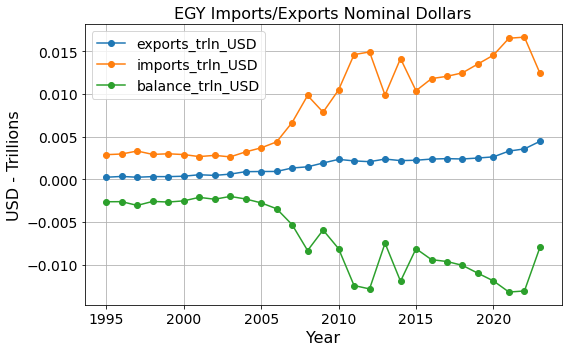

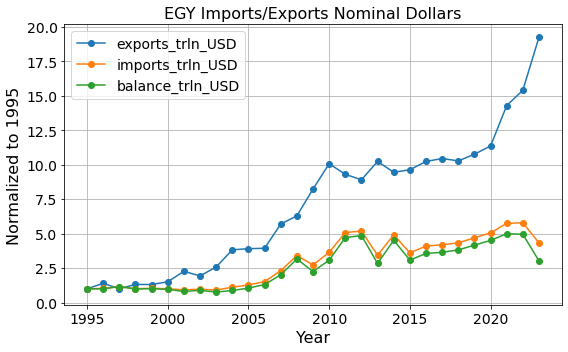

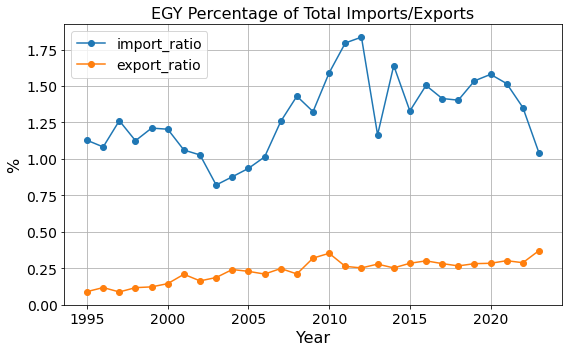

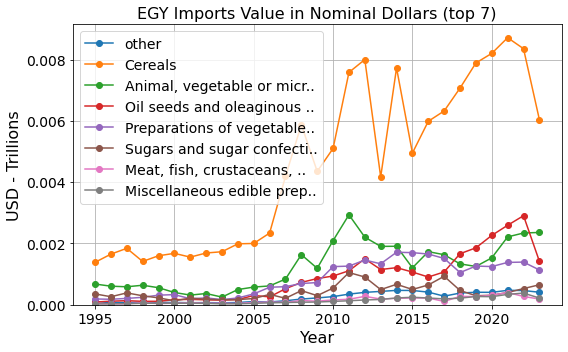

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


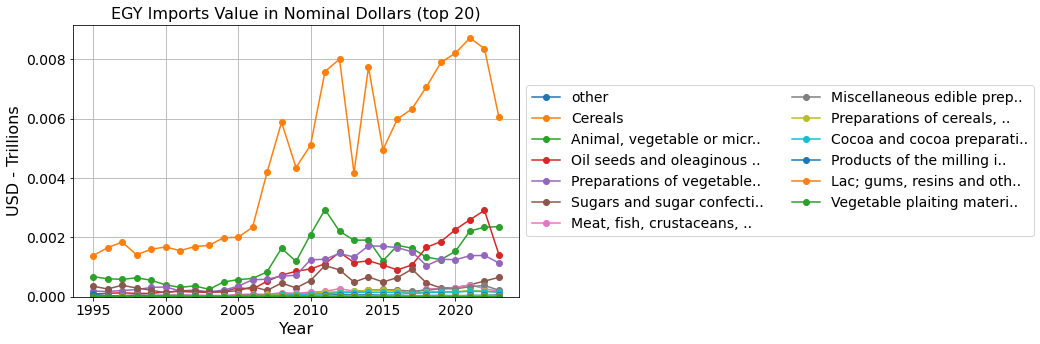

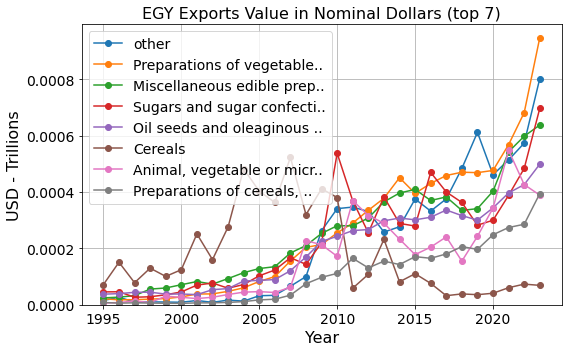

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


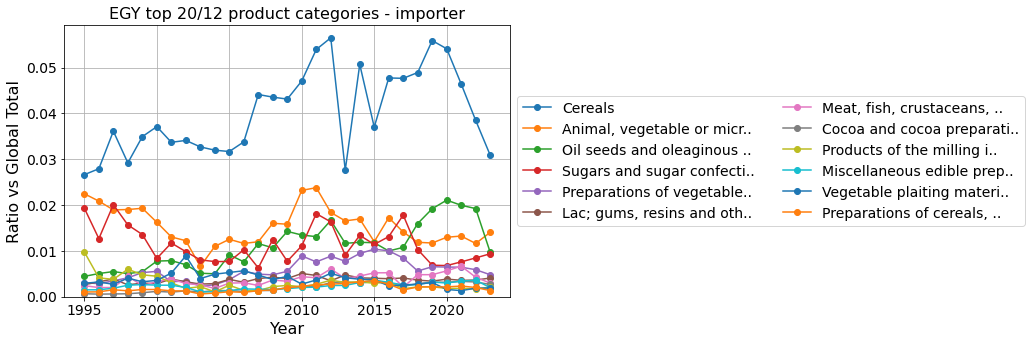

In [24]:
plot_for_country(df_ch, "EGY", focus="importer")

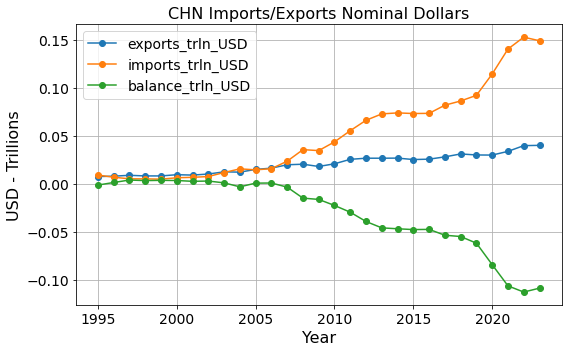

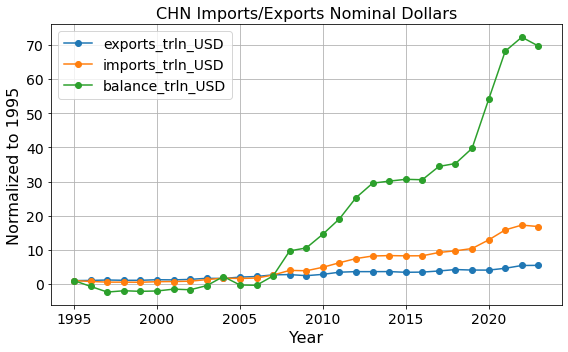

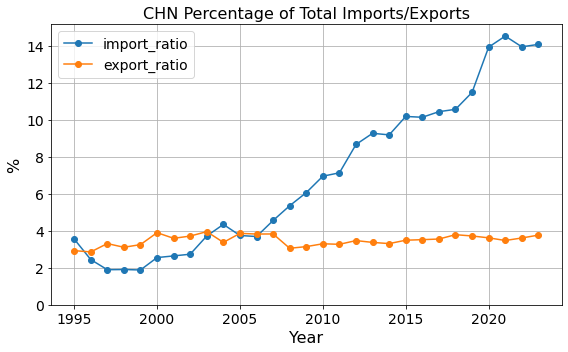

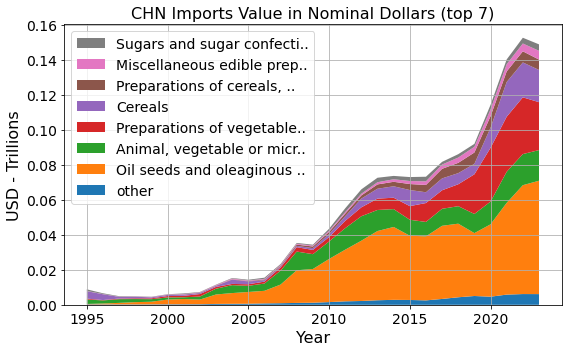

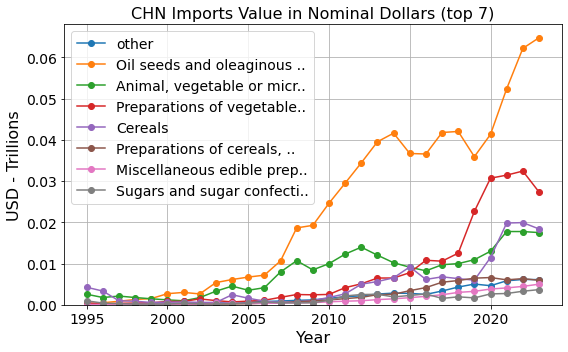

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


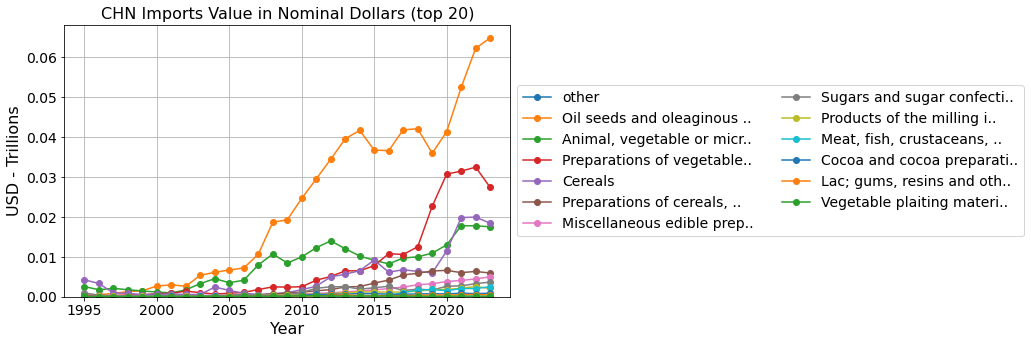

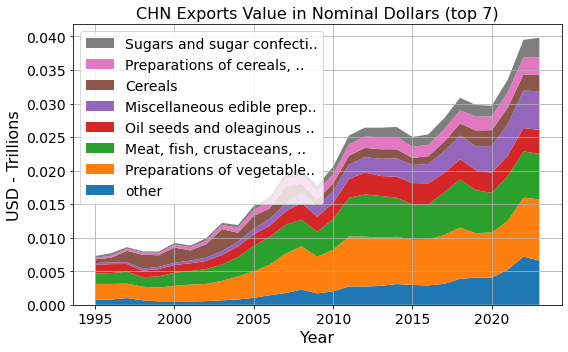

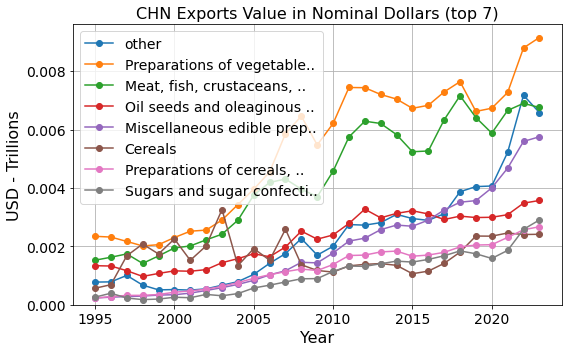

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


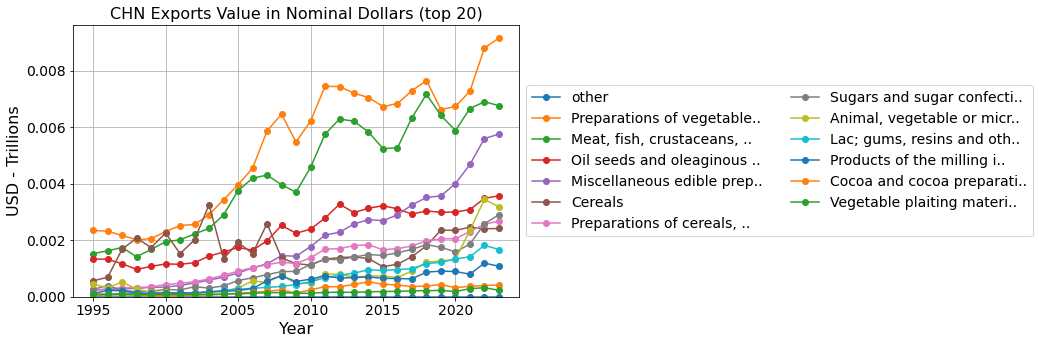

/home/prasopou/Documents/PhD/Courses/DataVis/Team37/src/eda/../util.py:138: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


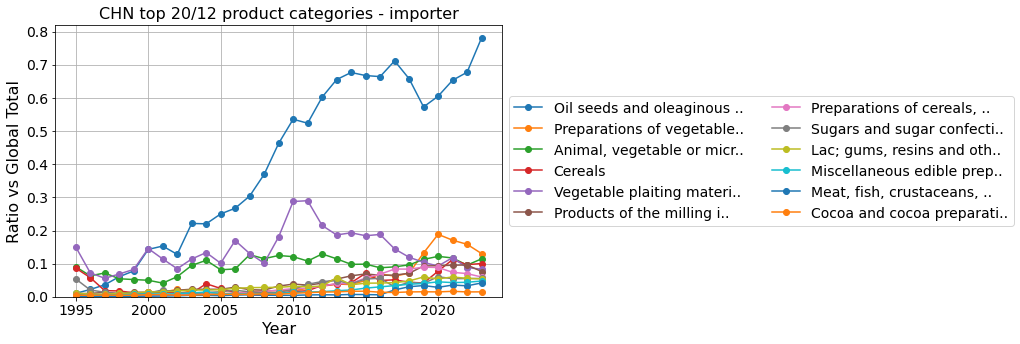

In [25]:
plot_for_country(df_ch, "CHN", focus="importer")

In [26]:
df_ch = data_df.copy()
df_ch = df_ch[df_ch["product_chapter"].isin(food_chapters)]
print(df_ch)

          year  exporter  importer product_chapter    value  quantity
4         1995         4        40              12   38.590    31.800
11        1995         4       124              12  110.004   105.976
21        1995         4       140              10  151.064   618.875
23        1995         4       148              10  153.551   539.312
74        1995         4       233              21   11.988     5.187
...        ...       ...       ...             ...      ...       ...
21371274  2023       894       842              12   81.706     7.675
21371275  2023       894       842              15   40.180    12.484
21371276  2023       894       842              17    0.046     0.005
21371277  2023       894       842              19    0.730     0.262
21371278  2023       894       842              21    0.045     0.033

[2539596 rows x 6 columns]


In [27]:
df_ch_imports = df_ch.groupby(["year", "importer"]).agg({"value": "sum", "quantity": "sum"})
df_ch_exports = df_ch.groupby(["year", "exporter"]).agg({"value": "sum", "quantity": "sum"})
df_ch_imports.rename_axis(index={"importer": "country"}, inplace=True)
df_ch_exports.rename_axis(index={"exporter": "country"}, inplace=True)
df_ch_net = df_ch_exports - df_ch_imports

tmp = df_ch_net.reset_index(inplace=False)
def count_negative(series: pd.Series):
    return (series < 0).sum()
def count_positive(series: pd.Series):
    return (series > 0).sum()
df_ch_net_importers = tmp.groupby("year").agg({"value": count_negative, "quantity": count_negative})
df_ch_net_exporters = tmp.groupby("year").agg({"value": count_positive, "quantity": count_positive})

<Axes: xlabel='year'>

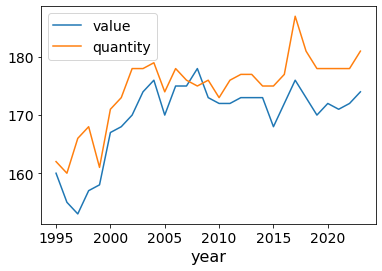

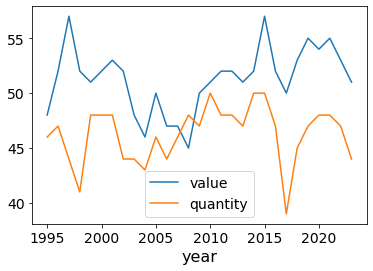

In [28]:
df_ch_net_importers.plot()
df_ch_net_exporters.plot()

<Axes: xlabel='year'>

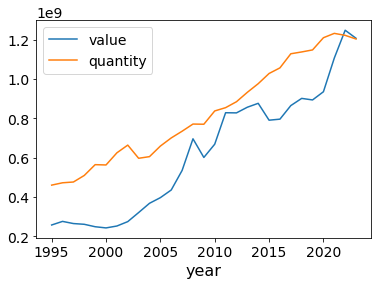

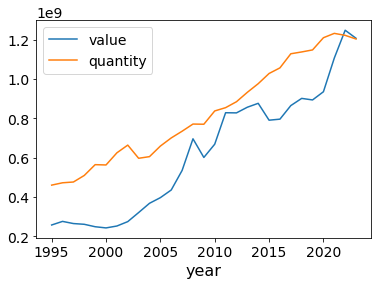

In [29]:
# Plot total imports in $ and weight
df_ch_imports.reset_index(inplace=True)
df_ch_imports = df_ch_imports.groupby(["year"]).agg({"value": "sum", "quantity": "sum"})
df_ch_imports.plot()

df_ch_exports.reset_index(inplace=True)
df_ch_exports = df_ch_exports.groupby(["year"]).agg({"value": "sum", "quantity": "sum"})
df_ch_exports.plot()

                    value     quantity
year country                          
1995 4         -25683.721   -81773.311
     8         -99878.775  -195635.793
     12      -2431958.138 -7662433.124
     20        -99747.478   -55750.807
     24       -281149.091  -597540.645
...                   ...          ...
2023 862     -1961153.734 -3449498.558
     876       -12840.582    -4293.103
     882       -97830.201   -81410.379
     887     -3676195.897 -5433798.767
     894        86827.512   222716.656

[6447 rows x 2 columns]
      surplus_value  surplus_quant
year                              
1995   9.551013e+07   2.398742e+08
1996   1.070005e+08   2.380668e+08
1997   1.022329e+08   2.338442e+08
1998   9.586404e+07   2.389079e+08
1999   9.065739e+07   2.613288e+08
2000   8.938314e+07   2.319360e+08
2001   9.350214e+07   2.467939e+08
2002   9.719281e+07   2.685398e+08
2003   1.093797e+08   2.600009e+08
2004   1.293012e+08   2.983435e+08
2005   1.323468e+08   2.784762e+08
2006   1.4477

<Axes: xlabel='year'>

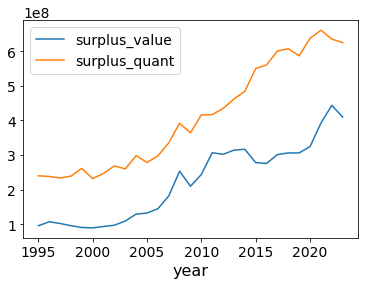

In [30]:
print(df_ch_net)
df = df_ch_net.copy()
df.reset_index(inplace=True)
surplus_countries = df[df["value"] > 0]
surplus_countries = surplus_countries.groupby(["year"]).agg({"value": "sum", "quantity": "sum"})
deficit_countries = df[df["value"] < 0]
deficit_countries = deficit_countries.groupby(["year"]).agg({"value": "sum", "quantity": "sum"})

df = pd.DataFrame()
df["surplus_value"] = surplus_countries["value"]
df["surplus_quant"] = surplus_countries["quantity"]


print(df)
df.plot()

In [31]:
world_gdp = [
    (1995, 31140.61),
    (1996, 31857.69),
    (1997, 31752.30),
    (1998, 31697.04),
    (1999, 32731.00),
    (2000, 33839.39),
    (2001, 33626.96),
    (2002, 34917.70),
    (2003, 39152.14),
    (2004, 44116.24),
    (2005, 47760.32),
    (2006, 51749.81),
    (2007, 58314.87),
    (2008, 64072.30),
    (2009, 60718.26),
    (2010, 66514.17),
    (2011, 73957.79),
    (2012, 75603.98),
    (2013, 77751.37),
    (2014, 79894.39),
    (2015, 75359.66),
    (2016, 76588.03),
    (2017, 81550.96),
    (2018, 86686.87),
    (2019, 87945.57),
    (2020, 85577.72),
    (2021, 97527.03),
    (2022, 101225.06),
    (2023, 105435.04)
]


In [32]:
gdp = pd.DataFrame(world_gdp)
gdp.rename(columns={0: 'year', 1: 'value'}, inplace=True)
gdp.set_index("year", inplace=True)
gdp = gdp.mul(1000*1000*1000) # from billions to USD


      surplus_value  surplus_quant
year                              
1995   9.551013e+07   2.398742e+08
1996   1.070005e+08   2.380668e+08
1997   1.022329e+08   2.338442e+08
1998   9.586404e+07   2.389079e+08
1999   9.065739e+07   2.613288e+08
2000   8.938314e+07   2.319360e+08
2001   9.350214e+07   2.467939e+08
2002   9.719281e+07   2.685398e+08
2003   1.093797e+08   2.600009e+08
2004   1.293012e+08   2.983435e+08
2005   1.323468e+08   2.784762e+08
2006   1.447701e+08   2.973975e+08
2007   1.815157e+08   3.349223e+08
2008   2.533065e+08   3.918916e+08
2009   2.097768e+08   3.643296e+08
2010   2.438255e+08   4.158797e+08
2011   3.066463e+08   4.167645e+08
2012   3.020401e+08   4.345290e+08
2013   3.140870e+08   4.616875e+08
2014   3.166850e+08   4.839859e+08
2015   2.780859e+08   5.498143e+08
2016   2.757361e+08   5.604247e+08
2017   3.013946e+08   6.004791e+08
2018   3.059497e+08   6.071356e+08
2019   3.060945e+08   5.867042e+08
2020   3.244009e+08   6.373820e+08
2021   3.921370e+08 

<Axes: xlabel='year'>

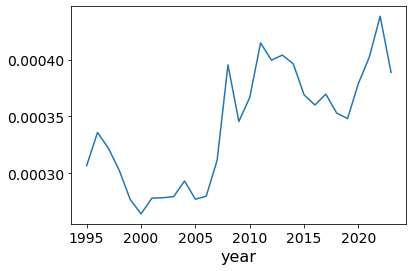

In [33]:
print(df)
print(gdp)

exp_pcnt_gdp = (df["surplus_value"] / gdp["value"]).mul(100.0)
print(exp_pcnt_gdp)
exp_pcnt_gdp.plot()